In [3]:
pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    mean_absolute_error, r2_score, mean_squared_error,
    roc_curve, auc, precision_recall_curve, f1_score, make_scorer,fbeta_score
)
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_sample_weight
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.utils.class_weight import compute_sample_weight

from dotenv import load_dotenv
import os

c:\Users\Andrew Shade\AppData\Local\Programs\Python\Python312\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [5]:
# Loads environment variables from a .env file into os.environ
load_dotenv()

class UnifiedOceanModel:
    """
    A unified wrapper for XGBoost training, tuning, and evaluation.
    
    Supports Binary Classification (Go/No-Go), Multi-class Classification 
    (Poor/Fair/Good/Excellent), and Regression (continuous visibility).
    
    Attributes:
        data_path (Path): Filepath to the input parquet dataset.
        binary_mode (bool): If True, converts target to binary Go/No-Go.
        binary_threshold (int): The visibility (ft) cutoff for a 'Go' condition.
    """

    def __init__(self, data_path=None, binary_mode=False):
        # Pulls from .env if not provided, defaults to 'training_data.parquet'
        env_path = os.getenv("OCEAN_DATA_PATH")
        self.data_path = Path(data_path or env_path)
        
        self.binary_mode = binary_mode
        self.binary_threshold = int(os.getenv("BINARY_THRESHOLD", 20))
        
        self.model = None
        self.model_type = None 
        self.class_names = ['No-Go', 'Go'] if binary_mode else ['Poor', 'Fair', 'Good', 'Excellent']
        self.X_train, self.X_test, self.y_train, self.y_test = (None,) * 4

    def load_and_prep(self, test_size=0.2):
        """
        Loads parquet data, generates targets based on mode, and splits into train/test sets.

        Args:
            test_size (float): Proportion of dataset to include in the test split.
        """
        df = pd.read_parquet(self.data_path)
        X = df.drop(columns=['target', 'visibility_ft'], errors='ignore')
        
        if self.binary_mode:
            # Create binary target: 1 if visibility >= threshold, else 0
            y = (df['target'] >= self.binary_threshold).astype(int)
            self.model_type = 'binary'
        else:
            y = df['target']
            unique_vals = y.nunique()
            self.model_type = 'classifier' if unique_vals <= 4 else 'regressor'
            
        print(f"--- Mode: {self.model_type.upper()} | Threshold: {self.binary_threshold}ft ---")
        
        stratify = y if self.model_type in ['binary', 'classifier'] else None
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, stratify=stratify, random_state=42
        )

    def tune_hyperparameters(self, max_evals=100):
        """
        Performs Bayesian optimization using Hyperopt to find optimal XGBoost parameters.

        Optimizes for F2 score (Recall-weighted) in classification modes to minimize 
        false negatives (missing a good dive day).

        Args:
            max_evals (int): Number of iterations for the optimizer.

        Returns:
            dict: The best hyperparameters found, merged with static model configs.
        """
        space = {
            'max_depth': hp.quniform('max_depth', 3, 11, 1),
            'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
            'subsample': hp.uniform('subsample', 0.6, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
            'gamma': hp.uniform('gamma', 0, 0.7),
        }

        # Define scoring and objectives based on mode
        if self.model_type == 'binary':
            scoring = make_scorer(fbeta_score, beta=2, zero_division=0)
        elif self.model_type == 'classifier':
            scoring = make_scorer(fbeta_score, beta=2, average='macro', zero_division=0)
        else:
            scoring = 'neg_mean_absolute_error'

        def objective(params):
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = 300
            params['random_state'] = 42
            
            if self.model_type == 'binary':
                # Balance positive class weights
                ratio = (self.y_train == 0).sum() / max(1, (self.y_train == 1).sum())
                m = xgb.XGBClassifier(**params, objective='binary:logistic', scale_pos_weight=ratio)
            elif self.model_type == 'classifier':
                m = xgb.XGBClassifier(**params, objective='multi:softprob', num_class=4)
            else:
                m = xgb.XGBRegressor(**params, objective='reg:squarederror')
                
            score = cross_val_score(m, self.X_train, self.y_train, cv=5, scoring=scoring).mean()
            return {'loss': -score, 'status': STATUS_OK}

        best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=Trials())
        
        # Merge optimized params with static defaults for final model construction
        best['max_depth'] = int(best['max_depth'])
        best['n_estimators'] = 300
        best['random_state'] = 42
        return best

    def predict_with_threshold(self, X, prob_threshold=0.3):
        """
        Predicts binary class using a custom probability threshold.
        
        Lowering the threshold increases Recall (catching more 'Go' days) at the 
        cost of Precision.

        Args:
            X (pd.DataFrame): Features to predict on.
            prob_threshold (float): Probability cutoff for positive class.

        Returns:
            np.array: Binary predictions (0 or 1).
        """
        if self.model_type != 'binary':
            raise ValueError("Threshold prediction only available in Binary Mode.")
        
        probs = self.model.predict_proba(X)[:, 1]
        return (probs >= prob_threshold).astype(int)
    
    def _evaluate_regressor(self, preds):
        """Internal helper to print regression metrics and plot residuals."""
        mae = mean_absolute_error(self.y_test, preds)
        rmse = np.sqrt(mean_squared_error(self.y_test, preds))
        r2 = r2_score(self.y_test, preds)
        print(f"\n--- Regression Stats (Raw Feet) ---\nMAE: {mae:.2f} ft | RMSE: {rmse:.2f} ft | R2: {r2:.4f}")
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        sns.regplot(x=self.y_test, y=preds, ax=axes[0], 
                    scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        axes[0].set_xlabel("Actual Visibility (ft)")
        axes[0].set_ylabel("Predicted Visibility (ft)")
        axes[0].set_title("Actual vs. Predicted")
        
        sns.histplot(self.y_test - preds, kde=True, ax=axes[1], color='purple')
        axes[1].set_title("Residual Distribution (Errors)")
        axes[1].set_xlabel("Error (ft)")
        plt.show()

    def _evaluate_classifier(self, preds):
        """Internal helper to print classification report and confusion matrix."""
        print(f"\n--- {self.model_type.upper()} Performance ---")
        print(classification_report(self.y_test, preds, target_names=self.class_names))
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(confusion_matrix(self.y_test, preds), annot=True, fmt='d', cmap='YlGnBu',
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.show()

    def run(self, max_evals=100, prob_eval=0.4):
        """
        Executes the full training pipeline: Load -> Tune -> Fit -> Evaluate.

        Args:
            max_evals (int): Hyperopt iterations.
            prob_eval (float): Probability threshold for binary evaluation.
        """
        self.load_and_prep()
        best_p = self.tune_hyperparameters(max_evals=max_evals)
        
        if self.model_type == 'binary':
            ratio = (self.y_train == 0).sum() / max(1, (self.y_train == 1).sum())
            best_p.update({'objective': 'binary:logistic', 'scale_pos_weight': ratio})
            self.model = xgb.XGBClassifier(**best_p)
            self.model.fit(self.X_train, self.y_train)
            preds = self.predict_with_threshold(self.X_test, prob_threshold=prob_eval)
        
        elif self.model_type == 'classifier':
            best_p.update({'objective': 'multi:softprob', 'num_class': 4})
            self.model = xgb.XGBClassifier(**best_p)
            weights = compute_sample_weight(class_weight='balanced', y=self.y_train)
            self.model.fit(self.X_train, self.y_train, sample_weight=weights)
            preds = self.model.predict(self.X_test)
            
        else:
            best_p.update({'objective': 'reg:squarederror'})
            self.model = xgb.XGBRegressor(**best_p)
            self.model.fit(self.X_train, self.y_train)
            preds = self.model.predict(self.X_test)
            
        if self.model_type in ['binary', 'classifier']:
            self._evaluate_classifier(preds)
        else:
            self._evaluate_regressor(preds)
        
        importances = pd.Series(self.model.feature_importances_, index=self.X_train.columns)
        importances.sort_values().tail(15).plot(kind='barh', color='midnightblue')
        plt.title("Key Visibility Drivers")
        plt.show()

    def save(self, filename="cove_binary_model.json"):
        """Saves the trained XGBoost model to JSON."""
        if self.model: 
            self.model.save_model(filename)
            print(f"Model saved to {filename}")

In [ ]:
uom = UnifiedOceanModel("visibility_data_reg.parquet")
uom.run(100)

--- Mode: REGRESSOR | Threshold: 20ft ---
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

 19%|█▉        | 19/100 [00:38<04:42,  3.49s/trial, best loss: 3.7584345475123833]

--- Mode: CLASSIFIER | Threshold: 20ft ---
100%|██████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: -0.43233074146475925]

--- CLASSIFIER Performance ---
              precision    recall  f1-score   support

        Poor       0.89      0.95      0.92        85
        Fair       0.50      0.11      0.18         9
        Good       0.50      0.50      0.50         8
   Excellent       0.00      0.00      0.00         2

    accuracy                           0.83       104
   macro avg       0.47      0.39      0.40       104
weighted avg       0.81      0.83      0.81       104



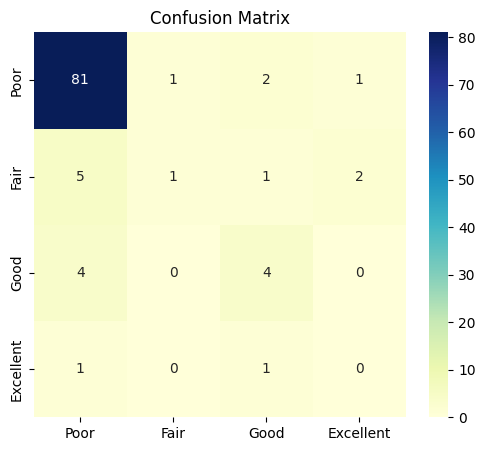

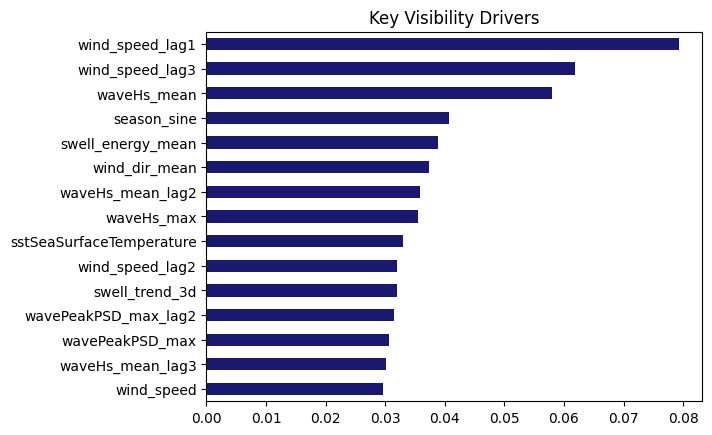

In [ ]:
uom = UnifiedOceanModel("visibility_data_class.parquet")
uom.run(100)

--- Mode: BINARY | Threshold: 20ft ---
100%|██████████| 100/100 [00:40<00:00,  2.46trial/s, best loss: -0.4990790588363896]

--- BINARY Performance ---
              precision    recall  f1-score   support

       No-Go       0.94      0.85      0.89        93
          Go       0.30      0.55      0.39        11

    accuracy                           0.82       104
   macro avg       0.62      0.70      0.64       104
weighted avg       0.87      0.82      0.84       104



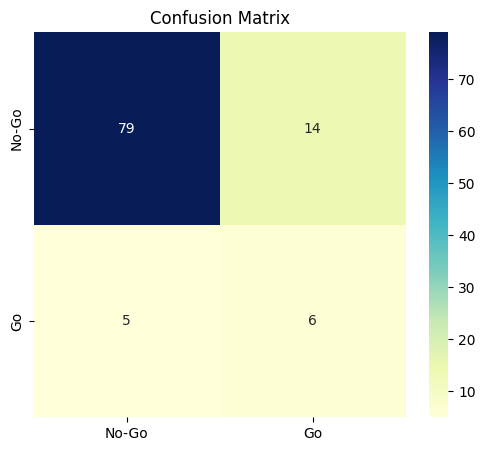

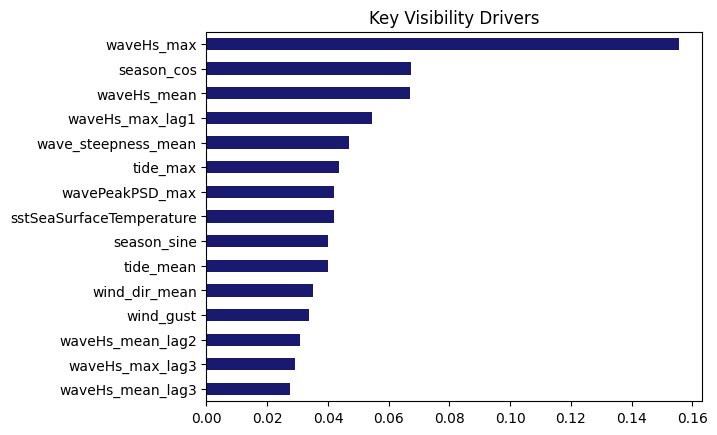

In [ ]:
# 1. Initialize with binary_mode=True and the 20ft cutoff
uom = UnifiedOceanModel(
    data_path="visibility_data_reg.parquet",
    binary_mode=True, 
    binary_threshold=20
)

# 2. Run with 100 tuning iterations and the 0.4 sensitivity threshold
uom.run(max_evals=100, prob_eval=0.4)